# Natural Language Processing Walkthrough

This walkthrough will go through different ways to handle textual data. Everyday, huge amounts of textual data are generated and NLP techniques help in analyzing this vast amount of data by extracting insights. Pulled from Kaggle this dataset includes over 20k reviews from tripadvisor.

### Dataset Overview

Dataset pulled from: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

Only two columns:
* Reviews
* Ratings


### Overall Goals
* Review the data set
* Most popular words in the reviews
* N grams (cluster of words - bigram = 2 word pairs, trigram = 3 word group)
* Word Cloud (visual representations of text data where the size of each word indicates its frequency)

### Review Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

In [2]:
# Load the dataset
file_path = 'files/tripadvisor_hotel_reviews.csv' 
data = pd.read_csv(file_path)


# Display basic information about the dataset and the first few rows
data_info = data.info()
data_head = data.head()


print(f'''\n{'-'*60}\nData Sample:\n{data_head}\n{'-'*60}''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB

------------------------------------------------------------
Data Sample:
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5
------------------------------------------------------------


* 2 columns: 1 int64 (numerical) and 1 object type (text)

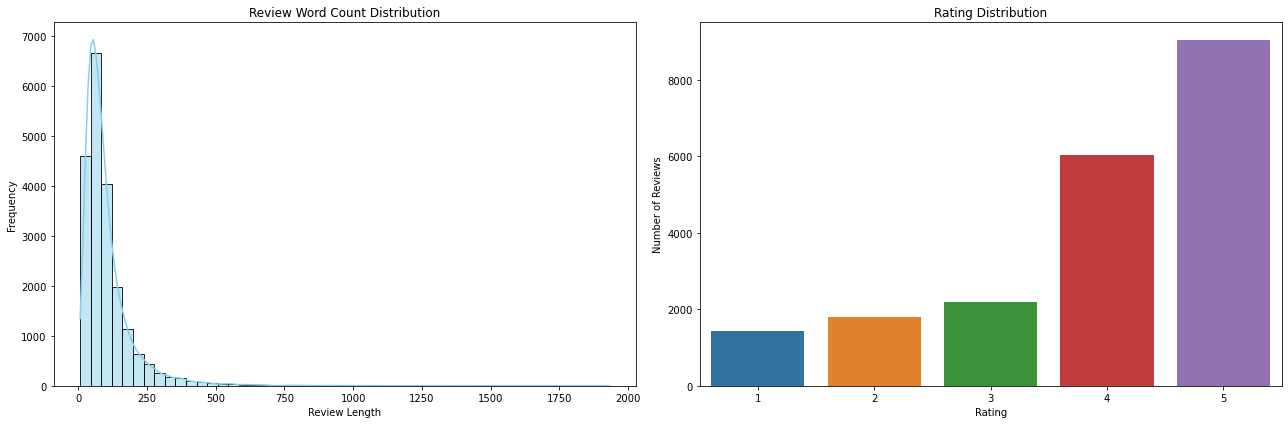


------------------------------------------------------------
Ratings Count
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64
------------------------------------------------------------
Review Character Count:
count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Review_Length, dtype: float64
------------------------------------------------------------
Review Word Count
count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Review_Word_Count, dtype: float64



In [3]:
## Review Length Analysis
data['Review_Length'] = data['Review'].apply(len)
review_length_summary = data['Review_Length'].describe()

# Review Length Analysis (counting words instead of characters)
data['Review_Word_Count'] = data['Review'].apply(lambda x: len(x.split()))
review_word_count_summary = data['Review_Word_Count'].describe()

# Rating Distribution
rating_counts = data['Rating'].value_counts().sort_index()

# Plotting the Review Length Distribution and Rating Distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Review Length Distribution
sns.histplot(data['Review_Word_Count'], bins=50, ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Review Word Count Distribution')
axes[0].set_xlabel('Review Length')
axes[0].set_ylabel('Frequency')

# Rating Distribution
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[1])
axes[1].set_title('Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Number of Reviews')

plt.tight_layout()
plt.show()

print(f'''\n{'-'*60}
Ratings Count\n{rating_counts}\n{'-'*60}
Review Character Count:\n{review_length_summary}\n{'-'*60}
Review Word Count\n{review_word_count_summary}
''')


* 20k reviews
* avg of 100 word reviews in this data set
* most ratings are 5 star - a bit surprised by this
    * I don't have a reference point for what the distribution should be for reviews but I suppose low review options don't last and change hands or hotels offer incentives to leave good reviews so it padds the positive or data set only includes hotels with x amount of reviews which might result in an overlap of high reviewed / popular hotels    
    * for the sake of the walkthrough we wont explore our data source anymore and instead focus on how to code n grams and word clouds with python. 


### Most Popular Words 

In [4]:
# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

# List of stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Tokenization and preprocessing
#split review into single words (tokens)
data['Tokens'] = data['Review'].apply(lambda x: word_tokenize(x.lower()))
#filter out stop words (is am are etc..) and words that are all characters (Helw#$#@o)
data['Filtered_Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


In [6]:
data.head()

,Review,Rating,Review_Length,Review_Word_Count,Tokens,Filtered_Tokens
0,nice hotel expensive parking got good deal sta...,4,593,87,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,1689,250,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member..."
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217,"[nice, rooms, not, 4, *, experience, hotel, mo...","[nice, rooms, experience, hotel, monaco, seatt..."
3,"unique, great stay, wonderful time hotel monac...",5,600,89,"[unique, ,, great, stay, ,, wonderful, time, h...","[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,1281,191,"[great, stay, great, stay, ,, went, seahawk, g...","[great, stay, great, stay, went, seahawk, game..."


* Code above splits the reviews into 'tokens' or smaller pieces of text (words in this case) 
* The tokens are then filtered to remove a list of stop words (a, not, am etc.. ) row has not and 4* 
    * industry expertise can help shape what should be included in the list of stop words. 
        * if its you're restaurant you can filter out restaurant name , location, etc from the reviews
        * if you're less familiar you can see how analysis go with the basic stop word list and filter later as I did in this notebook, you'll see later where I removed punta cana hotel from analysis.

In [7]:
# Flatten the list of tokens and count the words
all_words = [word for tokens in data['Filtered_Tokens'] for word in tokens]
word_counts = Counter(all_words)

# Most common words
most_common_words = word_counts.most_common(20)

In [8]:
#side note: breaking down all_words = [word for tokens in data['Filtered_Tokens'] for word in tokens] is not very intuative
for tokens in data['Filtered_Tokens'].head(2):
    for word in tokens:
        print(tokens)
        print(word)
    

['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'pay', 'parking', 'night']
nice
['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'valet', 'parking', 'check', 'quick', 'easy', 'littl

In [9]:
all_words[0:10]

['nice',
 'hotel',
 'expensive',
 'parking',
 'got',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary']

all_words = [word for tokens in data['Filtered_Tokens'] for word in tokens] is not very intuative
* first part: for tokens in data['Filtered_Tokens']  
    * this returns every review as a list of words. first one will be ['nice', 'hotel', 'expensive',] etc...
* seocond part: for word in tokens
    * this iterates over every word in the list from above. nice, hotel, expensive etc .... 
* word
    * this is a list of all the words in each review

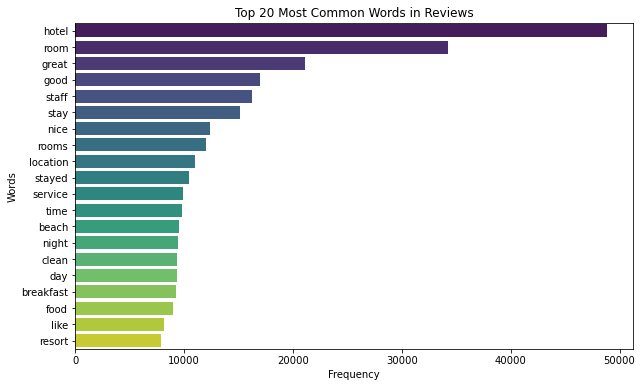

[('hotel', 48811),
 ('room', 34270),
 ('great', 21090),
 ('good', 16966),
 ('staff', 16197),
 ('stay', 15142),
 ('nice', 12403),
 ('rooms', 12003),
 ('location', 11013),
 ('stayed', 10465),
 ('service', 9939),
 ('time', 9810),
 ('beach', 9566),
 ('night', 9417),
 ('clean', 9359),
 ('day', 9331),
 ('breakfast', 9266),
 ('food', 8971),
 ('like', 8115),
 ('resort', 7910)]

In [10]:
# Plotting the Word Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for word, count in most_common_words], y=[word for word, count in most_common_words], palette='viridis')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

most_common_words

* first pass of word counts we see hotel, room great, good, staff leading the word counts
* since most of the reviews are 4 / 5 this most likely means the good reviews have good staff, room which makes sense
* next lets start looking at n grams

### N Grams
Finding popular words tells us a bit about the reviews. Better would be to group words in pairs, or triplets, etc... 

In [11]:
# Function to generate and count ngrams
def generate_ngrams(tokens_list, n):
    ngrams_list = ngrams(tokens_list, n)
    ngrams_counts = Counter(ngrams_list)
    return ngrams_counts

# Generating bigrams (2-grams) and trigrams (3-grams)
data['Bigrams'] = data['Filtered_Tokens'].apply(lambda x: generate_ngrams(x, 2))
data['Trigrams'] = data['Filtered_Tokens'].apply(lambda x: generate_ngrams(x, 3))

In [12]:
data.head()

,Review,Rating,Review_Length,Review_Word_Count,Tokens,Filtered_Tokens,Bigrams,Trigrams
0,nice hotel expensive parking got good deal sta...,4,593,87,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","{('nice', 'hotel'): 1, ('hotel', 'expensive'):...","{('nice', 'hotel', 'expensive'): 1, ('hotel', ..."
1,ok nothing special charge diamond member hilto...,2,1689,250,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","{('ok', 'nothing'): 1, ('nothing', 'special'):...","{('ok', 'nothing', 'special'): 1, ('nothing', ..."
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217,"[nice, rooms, not, 4, *, experience, hotel, mo...","[nice, rooms, experience, hotel, monaco, seatt...","{('nice', 'rooms'): 1, ('rooms', 'experience')...","{('nice', 'rooms', 'experience'): 1, ('rooms',..."
3,"unique, great stay, wonderful time hotel monac...",5,600,89,"[unique, ,, great, stay, ,, wonderful, time, h...","[unique, great, stay, wonderful, time, hotel, ...","{('unique', 'great'): 1, ('great', 'stay'): 1,...","{('unique', 'great', 'stay'): 1, ('great', 'st..."
4,"great stay great stay, went seahawk game aweso...",5,1281,191,"[great, stay, great, stay, ,, went, seahawk, g...","[great, stay, great, stay, went, seahawk, game...","{('great', 'stay'): 2, ('stay', 'great'): 1, (...","{('great', 'stay', 'great'): 1, ('stay', 'grea..."


In [13]:
data['Bigrams'].head()

0    {('nice', 'hotel'): 1, ('hotel', 'expensive'):...
1    {('ok', 'nothing'): 1, ('nothing', 'special'):...
2    {('nice', 'rooms'): 1, ('rooms', 'experience')...
3    {('unique', 'great'): 1, ('great', 'stay'): 1,...
4    {('great', 'stay'): 2, ('stay', 'great'): 1, (...
Name: Bigrams, dtype: object

* the generate n_grams creates groups or clusters of words. For bigrams its splitting 'nice hotel expensive parking got good ...' into two words groups. The pattern is grab words 1 and 2, then 2 and 3, then 3 and 4 etc... 'nice hotel', 'hotel expensive', 'expensive parking', 'got good'

In [14]:
# Initialize counters for bigrams and trigrams
bigram_counts = Counter()
trigram_counts = Counter()

# Sum the counts
for bigram_counter in data['Bigrams']:
    bigram_counts.update(bigram_counter)

for trigram_counter in data['Trigrams']:
    trigram_counts.update(trigram_counter)
    
# Most common bigrams and trigrams
most_common_bigrams = bigram_counts.most_common(20)
most_common_trigrams = trigram_counts.most_common(20)

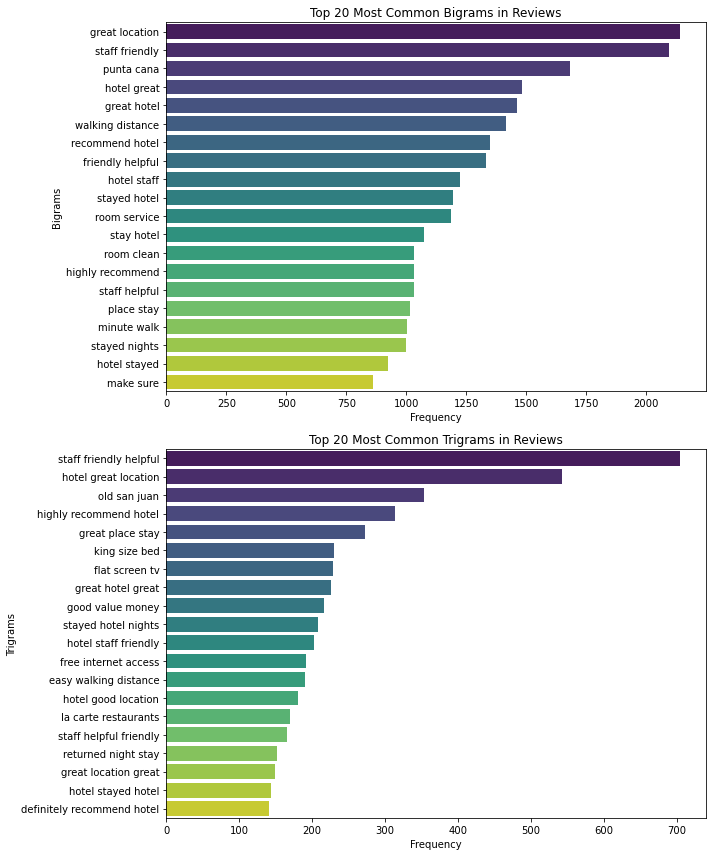

In [15]:
# Plotting the most common bigrams and trigrams
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Bigrams
sns.barplot(x=[count for bigram, count in most_common_bigrams], y=[' '.join(bigram) for bigram, count in most_common_bigrams], ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Common Bigrams in Reviews')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Bigrams')

# Trigrams
sns.barplot(x=[count for trigram, count in most_common_trigrams], y=[' '.join(trigram) for trigram, count in most_common_trigrams], ax=axes[1], palette='viridis')
axes[1].set_title('Top 20 Most Common Trigrams in Reviews')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Trigrams')

plt.tight_layout()
plt.show()


In [16]:
print(f'''\n{'-'*60}\nTop Bigrams:\n{most_common_bigrams}\n{'-'*60}
Top Trigrams:\n{most_common_trigrams}
''')


------------------------------------------------------------
Top Bigrams:
[(('great', 'location'), 2140), (('staff', 'friendly'), 2096), (('punta', 'cana'), 1681), (('hotel', 'great'), 1480), (('great', 'hotel'), 1461), (('walking', 'distance'), 1417), (('recommend', 'hotel'), 1348), (('friendly', 'helpful'), 1334), (('hotel', 'staff'), 1225), (('stayed', 'hotel'), 1196), (('room', 'service'), 1188), (('stay', 'hotel'), 1073), (('room', 'clean'), 1031), (('highly', 'recommend'), 1031), (('staff', 'helpful'), 1030), (('place', 'stay'), 1014), (('minute', 'walk'), 1003), (('stayed', 'nights'), 999), (('hotel', 'stayed'), 924), (('make', 'sure'), 863)]
------------------------------------------------------------
Top Trigrams:
[(('staff', 'friendly', 'helpful'), 704), (('hotel', 'great', 'location'), 543), (('old', 'san', 'juan'), 353), (('highly', 'recommend', 'hotel'), 314), (('great', 'place', 'stay'), 273), (('king', 'size', 'bed'), 230), (('flat', 'screen', 'tv'), 228), (('great', 'h

* Bigrams and Trigrams look a lot more useful. We can see great location and friendly staff top the list of reviews. Also some less helpful items like ('make', 'sure') and ('place', 'stay')
* What would be more useful is to see these split by rating to find patterns in low rated vs high rated reviews

In [17]:
# Function to aggregate and count n-grams for each rating
def aggregate_ngrams_by_rating(data, n):
    ngram_counts_by_rating = {}
    for rating in sorted(data['Rating'].unique()):
        # Filter reviews for the specific rating
        rating_data = data[data['Rating'] == rating]['Filtered_Tokens']
        
        # Flatten the list of filtered tokens for the specific rating
        all_filtered_tokens_rating = [token for sublist in rating_data for token in sublist]
        
        # Generating and counting ngrams for the specific rating
        ngram_counts = generate_ngrams(all_filtered_tokens_rating, n)
        
        # Most common ngrams for the specific rating
        ngram_counts_by_rating[rating] = ngram_counts.most_common(10)
    
    return ngram_counts_by_rating

# Aggregating and counting bigrams and trigrams for each rating
bigrams_by_rating = aggregate_ngrams_by_rating(data, 2)
trigrams_by_rating = aggregate_ngrams_by_rating(data, 3)

bigrams_by_rating, trigrams_by_rating

({1: [(('punta', 'cana'), 150),
   (('credit', 'card'), 110),
   (('customer', 'service'), 103),
   (('stay', 'hotel'), 101),
   (('star', 'hotel'), 95),
   (('hotel', 'staff'), 85),
   (('room', 'service'), 83),
   (('worst', 'hotel'), 82),
   (('hotel', 'room'), 77),
   (('stay', 'away'), 75)],
  2: [(('punta', 'cana'), 198),
   (('room', 'service'), 140),
   (('staff', 'friendly'), 124),
   (('star', 'hotel'), 121),
   (('air', 'conditioning'), 120),
   (('stay', 'hotel'), 102),
   (('san', 'juan'), 97),
   (('great', 'location'), 96),
   (('stayed', 'hotel'), 90),
   (('make', 'sure'), 87)],
  3: [(('great', 'location'), 248),
   (('staff', 'friendly'), 235),
   (('punta', 'cana'), 202),
   (('good', 'location'), 166),
   (('room', 'clean'), 138),
   (('hotel', 'great'), 133),
   (('room', 'service'), 133),
   (('walking', 'distance'), 131),
   (('san', 'juan'), 125),
   (('stayed', 'hotel'), 124)],
  4: [(('great', 'location'), 811),
   (('staff', 'friendly'), 728),
   (('hotel', 

#### Low-Rated Reviews (Ratings 1 and 2):

Bigrams:

* Focus on specific issues: Common bigrams in low-rated reviews often refer to specific problems or deficiencies, such as 'credit card', 'customer service', 'room service', and 'air conditioning'.
* Negative experiences: Phrases like 'worst hotel' and 'room small' indicate dissatisfaction and negative experiences.
* Location-specific complaints: The occurrence of 'punta cana' suggests location-specific issues or expectations not being met.

Trigrams:

* Detailed grievances: The trigrams often narrate specific negative experiences, like 'worst hotel stayed', 'finally got room', and 'worst hotel experience'.
* Descriptions of discomfort or inconvenience: Phrases such as 'king size bed' and 'air conditioning' might be associated with complaints about facilities or comfort.

#### High-Rated Reviews (Ratings 4 and 5):

Bigrams:

* Positive descriptions: High-rated reviews frequently include complimentary phrases like 'great location', 'staff friendly', 'great hotel', and 'highly recommend'.
* Emphasis on service and experience: Words like 'staff', 'great', 'hotel', and 'recommend' suggest a focus on the quality of service and overall positive experiences.

Trigrams:

* Descriptions of excellence: Trigrams in high-rated reviews often reflect satisfaction and positive experiences, such as 'hotel great location', 'staff friendly helpful', 'highly recommend hotel', and 'great hotel great'.
* Positive narratives: Phrases like 'great place stay', 'easy walking distance', and 'free internet access' indicate convenience, satisfaction with amenities, and overall positive sentiment.

### Word Cloud
Lets Visualize the data by rating and an example of how to start filtering out data

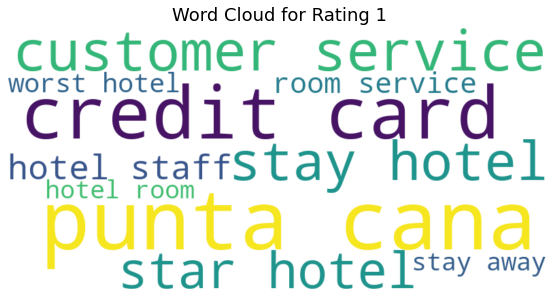

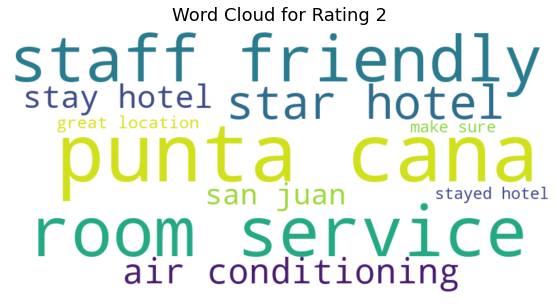

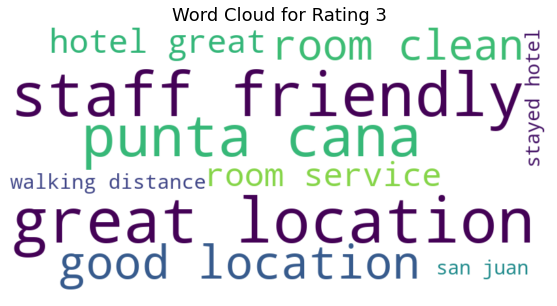

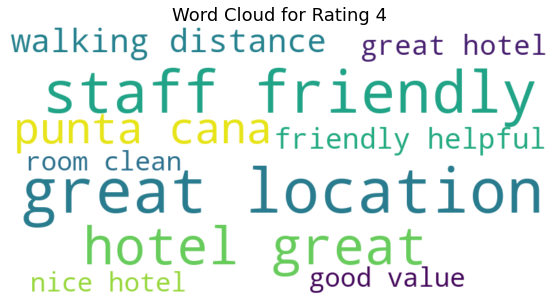

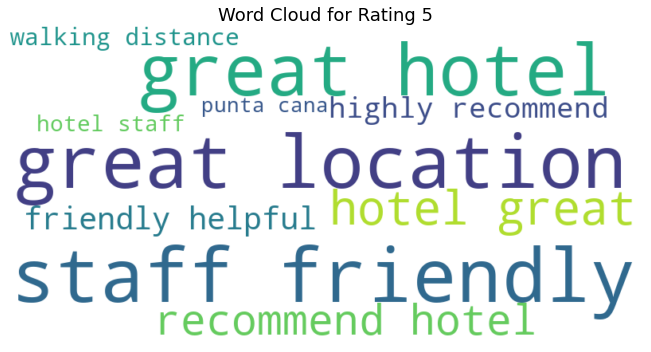

In [18]:
# Function to generate word cloud
def generate_wordcloud(ngram_counts, title):
    # Combine the words and counts into a single string for the word cloud
    word_freq = { ' '.join(k): v for k, v in ngram_counts.items() }
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')

# Generate and display word clouds for each rating
for rating in sorted(data['Rating'].unique()):
    # Combine bigrams and trigrams for the word cloud
    #combined_ngrams = bigrams_by_rating[rating] + trigrams_by_rating[rating]
    generate_wordcloud(dict(bigrams_by_rating[rating]), f'Word Cloud for Rating {rating}')

plt.tight_layout()
plt.show()

* Punta Cana not looking great based on these review (not stopping me from hopefully taking a trip there this summer!) 
* Lets pretend all these reviews are from punta cana and we want to remove from our word cloud.

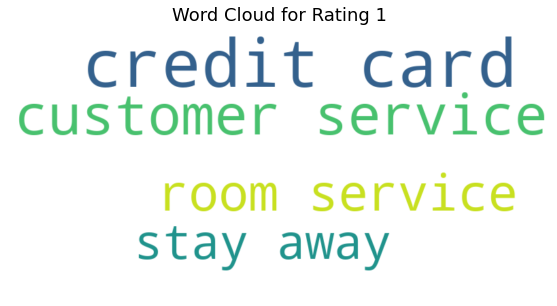

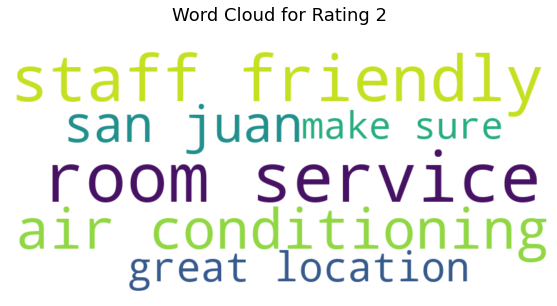

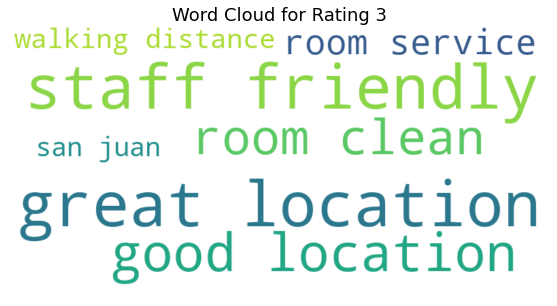

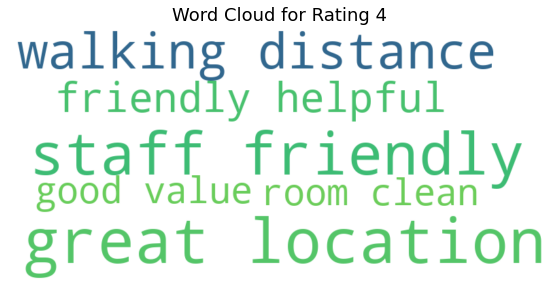

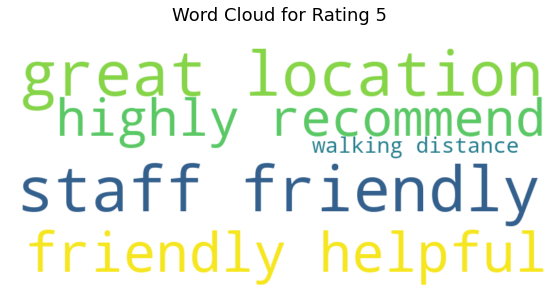

<Figure size 432x288 with 0 Axes>

In [19]:
# List of words to remove
words_to_remove = ['punta', 'cana', 'hotel']

# Function to generate word cloud
def generate_wordcloud(ngram_counts, title):
     # Remove unwanted words from n-grams
    filtered_ngram_counts = {ngram: count for ngram, count in ngram_counts.items()
                             if not any(word in ngram for word in words_to_remove)}

    # Remove unwanted words #single word, not for n grams
    #for word in words_to_remove:
        #ngram_counts.pop(word, None)  # Remove the word if it exists in the dictionary

    # Combine the words and counts into a single string for the word cloud
    #word_freq = { ' '.join(k): v for k, v in ngram_counts.items() }
    word_freq = {' '.join(k): v for k, v in filtered_ngram_counts.items()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()
    
# Generate and display word clouds for each rating
for rating in sorted(data['Rating'].unique()):
    # Combine bigrams and trigrams for the word cloud
    #combined_ngrams = bigrams_by_rating[rating] + trigrams_by_rating[rating]
    generate_wordcloud(dict(bigrams_by_rating[rating]), f'Word Cloud for Rating {rating}')

plt.tight_layout()
plt.show()